In [213]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
from statsmodels.api import OLS
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import chain
import seaborn 
import pickle
import sklearn.metrics as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor

## Pattern Statistics (all and experiment only) ##

In [214]:
## Get Experiment Pattern Indices ##
# Reasoning later in document #
test_patterns_indices = np.array([894, 423, 1367, 249, 939, 427, 590, 143, 912, 580, 1043, 673, 1359, 736, 678, 1355], dtype=float)
control_patterns = [678, 1355]
n_subjects = 43

In [215]:
## Extract Pattern Data ##
patterns_file = open(os.getcwd()+"/data/patterns.pkl", 'rb')
_patterns = pickle.load(patterns_file)
patterns_file.close()
n_patterns = len(_patterns)
print(n_patterns)

1378


In [216]:
## Partition Data ##
patterns = np.array([[[0, 0, 0] for x in range(16)] for y in range(n_patterns)], dtype=float) # (1378, 16, 3)

# Puts low/mid/high notes per step into workable array
for patt in range(n_patterns): # 1378
    for step in range(16): # 16
        for note in range(len(_patterns[patt][step])): # num notes on that step
            if _patterns[patt][step][note] == 1: # low channel note
                patterns[patt][step][0] += 1
            if _patterns[patt][step][note] == 2: # mid channel note
                patterns[patt][step][1] += 1
            if _patterns[patt][step][note] == 3: # high channel note
                patterns[patt][step][2] += 1

print("Example:")
for i in range(16):
    print(f"{i+1}: {_patterns[340][i]} --> {patterns[340][i]}")

Example:
1: [1, 3] --> [1. 0. 1.]
2: [2, 3] --> [0. 1. 1.]
3: [3, 2] --> [0. 1. 1.]
4: [2, 2] --> [0. 2. 0.]
5: [1, 2, 2, 3] --> [1. 2. 1.]
6: [] --> [0. 0. 0.]
7: [2, 3, 3] --> [0. 1. 2.]
8: [3] --> [0. 0. 1.]
9: [1, 2] --> [1. 1. 0.]
10: [3] --> [0. 0. 1.]
11: [2, 3, 2] --> [0. 2. 1.]
12: [2, 3] --> [0. 1. 1.]
13: [1, 2, 3] --> [1. 1. 1.]
14: [2, 3, 3] --> [0. 1. 2.]
15: [] --> [0. 0. 0.]
16: [2, 2] --> [0. 2. 0.]


In [217]:
## Characteristics of dataset patterns and selected patterns ##
note_counts = np.array([0.0 for x in range(5)], dtype=float) # [low,mid,high,rests,total]
exp_note_counts = note_counts.copy()

note_counts_by_step = np.array([[0.0 for x in range(4)] for y in range(16)], dtype=float) # [low,mid,high,total]
exp_note_counts_by_step = note_counts_by_step.copy()

for patt in range(n_patterns):
    for step in range(16):
        isrest=1
        for channel in range(3):
            value = patterns[patt][step][channel]
            
            if value > 0.1: # condition checking for all three channels not having a note
                isrest=0

            note_counts[channel] += value
            note_counts_by_step[step][channel] += value # per channel
            note_counts_by_step[step][3] += value # sum notes

            if np.isin(patt, test_patterns_indices): # if used in exp
                exp_note_counts[channel] += value
                exp_note_counts_by_step[step][channel] += value # per channel
                exp_note_counts_by_step[step][3] += value # sum notes

        if isrest==1: # remainder of rest check
            note_counts[3] += 1
            if np.isin(patt, test_patterns_indices):
                exp_note_counts[3] += 1
            

note_counts[4] = np.sum(note_counts[0:3])
exp_note_counts[4] = np.sum(exp_note_counts[0:3])
_note_counts_by_step = note_counts_by_step.T
_exp_note_counts_by_step = exp_note_counts_by_step.T
print(f"note cnts {note_counts}")
print(f"exp note cnts {exp_note_counts}")

for i in range(4):
    print(_note_counts_by_step[i])

note cnts [ 6238. 10708. 19208.  3799. 36154.]
exp note cnts [ 74. 113. 209.  48. 396.]
[1304.   10.  122.   48. 1240.  101.  371.  141. 1254.   40.   59.   15.
 1230.    9.  278.   16.]
[ 541.  286.  993.  350. 1571.  193.  706.  556.  414.  514.  966.  462.
 1566.  424.  651.  515.]
[1686.  593. 1740.  880. 1373.  582. 1714. 1085. 1419.  770. 1747.  879.
 1456.  943. 1579.  762.]
[3531.  889. 2855. 1278. 4184.  876. 2791. 1782. 3087. 1324. 2772. 1356.
 4252. 1376. 2508. 1293.]


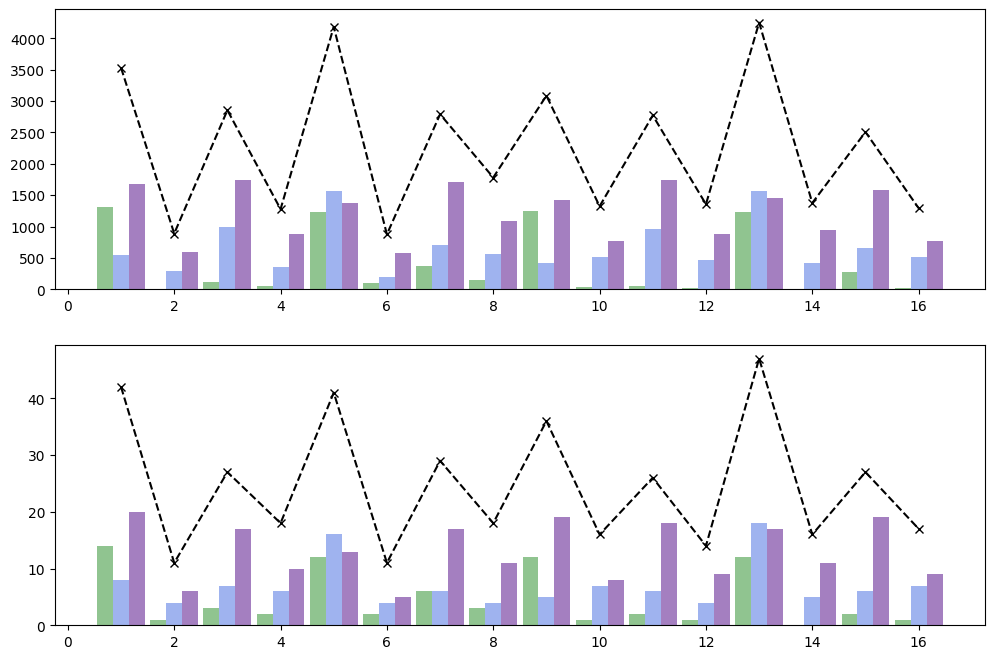

In [218]:
colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
idx = np.arange(16)+1
idx_l = idx-0.3
idx_r = idx+0.3
pos=[-0.45,0.0,0.45]
bar_width = 0.3
ax1.bar(idx_l,_note_counts_by_step[0],color=colors_dark[0], alpha=0.5, width=bar_width)
ax2.bar(idx_l,_exp_note_counts_by_step[0], color=colors_dark[0], alpha=0.5, width=bar_width)

ax1.bar(idx,_note_counts_by_step[1],color=colors_dark[1], alpha=0.5, width=bar_width)
ax2.bar(idx,_exp_note_counts_by_step[1], color=colors_dark[1], alpha=0.5, width=bar_width)

ax1.bar(idx_r,_note_counts_by_step[2],color=colors_dark[2], alpha=0.5, width=bar_width)
ax2.bar(idx_r,_exp_note_counts_by_step[2], color=colors_dark[2], alpha=0.5, width=bar_width)

ax1.plot(idx, np.sum(_note_counts_by_step[:3], axis=0), color='black', linestyle="--", marker="x")
ax2.plot(idx, np.sum(_exp_note_counts_by_step[:3], axis=0), color='black', linestyle="--", marker="x")
plt.show()

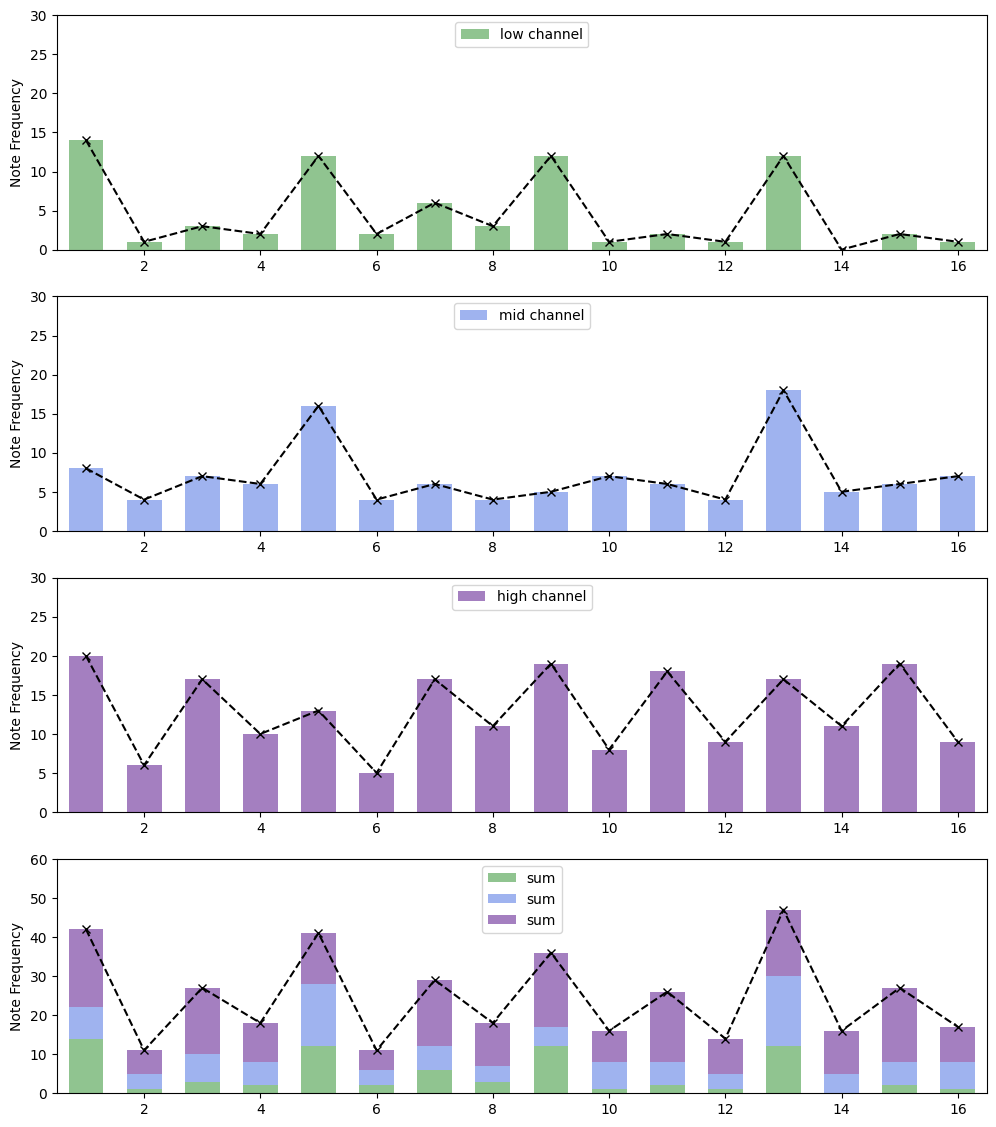

In [244]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,14))
#fig.subplots_adjust(hspace=0.3)

colors_light=['lightgreen','lightblue','mediumpurple']
colors_dark=['forestgreen', 'royalblue','indigo']
idx = np.arange(16)+1
idx_l = idx-0.3
idx_r = idx+0.3
pos=[-0.45,0.0,0.45]
bar_width = 0.6
ax1.bar(idx,_exp_note_counts_by_step[0], color=colors_dark[0], alpha=0.5, width=bar_width, label="low channel")

ax2.bar(idx,_exp_note_counts_by_step[1], color=colors_dark[1], alpha=0.5, width=bar_width, label="mid channel")

ax3.bar(idx,_exp_note_counts_by_step[2], color=colors_dark[2], alpha=0.5, width=bar_width, label="high channel")
bottom=np.array([0.0 for x in range(16)])
for i in range(3):
    ax4.bar(idx, _exp_note_counts_by_step[i], color=colors_dark[i], alpha=0.5,width=bar_width, label="sum", bottom=bottom)
    bottom += _exp_note_counts_by_step[i]

ax1.plot(idx, _exp_note_counts_by_step[0], color='black', linestyle="--", marker="x")
ax2.plot(idx, _exp_note_counts_by_step[1], color='black', linestyle="--", marker="x")
ax3.plot(idx, _exp_note_counts_by_step[2], color='black', linestyle="--", marker="x")
ax4.plot(idx, _exp_note_counts_by_step[3], color='black', linestyle="--", marker="x")

plts = [ax1,ax2,ax3,ax4]
for p in plts:
    p.legend(loc='upper center', ncols=1)
    p.set_xlim([0.5,16.5])
    p.set_ylim([0,30])
    p.set_ylabel("Note Frequency")
    ax4.set_ylim([0,60])
plt.show()


## Experiment Statistics ##

In [220]:
## Extract experiment data ##
data = []
tap_file = os.getcwd()+"/data/tap_rhythm_contour_raw.csv"
with open(tap_file) as results: 
    reader = csv.reader(results)
    for row in reader:
        data.append(row)
    results.close()


In [221]:
## Clean csv file (if necessary) ## 
_tap_data = []
for row in data:
    line = row[2:20]
    _tap_data.append(line)
for i in range(3):
    print(_tap_data[i])

['ID', 'NAME', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15', 't16']
['1355', 'breakbeat_unconventional_DMR_1', '0.716535433', '0', '0', '0', '0.661417323', '0', '0.700787402', '0', '0', '0', '0.716535433', '0', '0.732283465', '0', '0', '0']
['1043', 'chicago_promisedland_138', '0.496062992', '0', '0.417322835', '0', '0.488188976', '0', '0', '0', '0.42519685', '0', '0.456692913', '0', '0.480314961', '0', '0', '0']


In [222]:
tap_data = np.array([[[0.0 for x in range(16)] for y in range(n_subjects)] for z in range(len(_tap_data)-1)], dtype=float)
tap_data_pattern = np.array([[[0.0 for x in range(16)] for y in range(n_subjects)] for z in range(18)], dtype=float)

n=0
subj=0
ctrl=[0,0]
for patt in range(1, len(_tap_data)): # each row
    n+=1
    
    tap_data[patt-1][subj] = _tap_data[patt][2:]



    pattern_index = int(_tap_data[patt][0])

    if np.isin(pattern_index, test_patterns_indices):
        _pttn = np.where(pattern_index == test_patterns_indices)[0][0] # get index for saving
        pttn=_pttn

        # second control check
        if ctrl[0]>0 and ctrl[0]<2:
            pttn=16
        if ctrl[1]>0 and ctrl[1]<2:
            pttn=17

        tap_data_pattern[pttn][subj] = _tap_data[patt][2:]
        
        # control pattern counts
        if pattern_index==678:
            ctrl[0]+=1
        if pattern_index==1355:
            ctrl[1]+=1

    if n%18==0: # num patterns in exp
        subj+=1
        ctrl=[0,0]

print(tap_data.shape)
print(tap_data_pattern.shape)


(774, 43, 16)
(18, 43, 16)


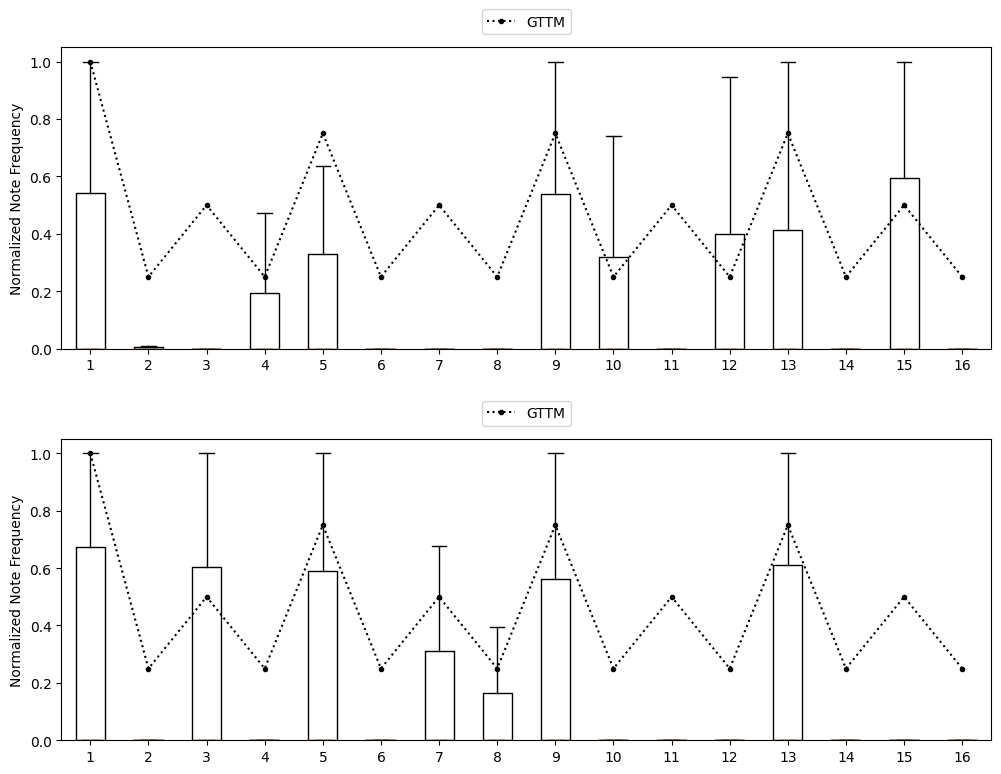

In [226]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,9))
fig.subplots_adjust(hspace=0.3)

idx = np.arange(16)+1
idx_l = idx-0.3
idx_r = idx+0.3
pos=[-0.45,0.0,0.45]
bar_width = 0.3

#gttm = np.array([5,1,2,1,3,1,2,1,4,1,2,1,3,1,2,1],dtype=float)
gttm = np.array([4,1,2,1,3,1,2,1,3,1,2,1,3,1,2,1],dtype=float)
gttm /= np.max(gttm)

patt1 = np.mean(tap_data_pattern[0], axis=0) / np.max(np.mean(tap_data_pattern[0], axis=0))
patt2 = np.mean(tap_data_pattern[1], axis=0) / np.max(np.mean(tap_data_pattern[1], axis=0))

#ax1.plot(idx, patt1, color='black', linestyle="-", marker=".", label="patt1")
#ax2.plot(idx, patt2, color='black', linestyle="-", marker=".", label='patt2')

bp1=ax1.boxplot(tap_data_pattern[0]/np.max(tap_data_pattern[0]), showfliers=False)
bp2=ax2.boxplot(tap_data_pattern[1]/np.max(tap_data_pattern[1]), showfliers=False)


## meaningless for now
#ax3.plot(idx, patt1, color='black', linestyle="-", marker=".", label="patt1")
#ax3.plot(idx, patt2, color='black', linestyle="-", marker=".", label='patt2')

plts = [ax1,ax2,]
for p in plts:
    p.plot(idx, gttm, color='black', linestyle=":", marker=".", label='GTTM')
    p.legend(loc='upper center', bbox_to_anchor=[0.5,1.15], ncols=5)
    p.set_ylim([0,1.05])
    p.set_ylabel("Normalized Note Frequency")

plt.show()